## Code for reading the HAR-UML dataset

In [1]:
import numpy as np

from source.read_HAR_dataset import read_har_dataset, har_dimensions

In [2]:
# [X_train, y_train, epochs, X_test, y_test, test_epochs, X_validation, y_validation, validation_epochs, kcal_MET, test_kcal_MET, validation_kcal_MET] = 

data = read_har_dataset('./datasets/HAR-UML20/')

ids_train, X_train, y_train, I_train, train_kcal_MET = data['train']

ids_val, X_val, y_val, I_val, val_kcal_MET = data['val']

ids_test, X_test, y_test, I_test, test_kcal_MET = data['test']

IDS: [2, 7, 0, 8, 4, 9, 5, 6, 3, 1]
Train IDS: [2, 7, 0, 8, 4, 9]
Test IDS: [5, 6]
Val IDS: [3, 1]
Training files: 6 - ['dataset_S1.csv', 'dataset_S2.csv', 'dataset_S3.csv', 'dataset_S4.csv', 'dataset_S5.csv', 'dataset_S6.csv']
Train epochs: 6 - ['dataset_S1_epochs.csv', 'dataset_S2_epochs.csv', 'dataset_S3_epochs.csv', 'dataset_S4_epochs.csv', 'dataset_S5_epochs.csv', 'dataset_S6_epochs.csv']
Testing files: 2 - ['dataset_S7.csv', 'dataset_S8.csv']
Testing epochs: 2 - ['dataset_S7_epochs.csv', 'dataset_S8_epochs.csv']
Validation files: 2 - ['dataset_S9.csv', 'dataset_S10.csv']
Validation epochs: 2 - ['dataset_S9_epochs.csv', 'dataset_S10_epochs.csv']


In [3]:
har_dimensions

array(['Accelerometer-X', 'Accelerometer-Y', 'Accelerometer-Z',
       'Gyrometer-X', 'Gyrometer-Y', 'Gyrometer-Z', 'Magnetometer-X',
       'Magnetometer-Y', 'Magnetometer-Z'], dtype='<U15')

In [4]:
from source.utils import create_dir, filter_dimensions, save_metrics2
dimensions = [
    'Accelerometer-X', 
    'Accelerometer-Y',
    'Accelerometer-Z',
    'Gyrometer-X',
    'Gyrometer-Y',
    'Gyrometer-Z'
]

X_train_f = filter_dimensions(X_train, har_dimensions, dimensions)
X_test_f = filter_dimensions(X_test, har_dimensions, dimensions)
X_val_f = filter_dimensions(X_val, har_dimensions, dimensions)

In [5]:
import os
import pandas as pd
import torch
from torch.utils.data import Dataset
import random

class ContrastiveDataset(Dataset):
    def __init__(self, X, y, use_label = False):
        self.X = X
        self.y = y
        self.classes = np.unique(y)
        self.classes_samples = {}
        self.use_label = use_label
        for i in range(len(self.classes)):
            c = self.classes[i]
            samples = np.where(c == y)[0]
            self.classes_samples[c] = samples
        
    def __len__(self):
        return len(self.X)

    def __getitem__(self, idx):
        if self.use_label:
            idx_c = self.y[idx][0]
            o_c = random.choice(np.delete(self.classes, idx_c))
            
            samples = self.classes_samples[o_c]
            
            rand_id = random.randint(0, len(samples) - 1)
            negative = self.X[samples[rand_id]]
            negative_label = self.y[samples[rand_id]]
        else:
            rand_id = random.randint(0, len(self.X) - 1)
            negative = self.X[rand_id]
            negative_label = self.y[rand_id]
        return self.X[idx], negative, self.y[idx], negative_label

In [6]:
from torch.utils.data import DataLoader

train_dataset = ContrastiveDataset(X_train_f.transpose([0, 2, 1]).astype(np.float32), y_train, use_label=False)
train_dataloader = DataLoader(train_dataset, batch_size=64, shuffle=True)
val_dataset = ContrastiveDataset(X_val_f.transpose([0, 2, 1]).astype(np.float32), y_val, use_label=False)
val_dataloader = DataLoader(val_dataset, batch_size=64, shuffle=True)
test_dataset = ContrastiveDataset(X_test_f.transpose([0, 2, 1]).astype(np.float32), y_test, use_label=False)
test_dataloader = DataLoader(test_dataset, batch_size=64, shuffle=True)

In [7]:

"""
Author: Yonglong Tian (yonglong@mit.edu)
Date: May 07, 2020
"""
from __future__ import print_function

import torch
import torch.nn as nn


class SupConLoss(nn.Module):
    """Supervised Contrastive Learning: https://arxiv.org/pdf/2004.11362.pdf.
    It also supports the unsupervised contrastive loss in SimCLR"""
    def __init__(self, temperature=0.07, contrast_mode='all',
                 base_temperature=0.07):
        super(SupConLoss, self).__init__()
        self.temperature = temperature
        self.contrast_mode = contrast_mode
        self.base_temperature = base_temperature

    def forward(self, features, labels=None, mask=None):
        """Compute loss for model. If both `labels` and `mask` are None,
        it degenerates to SimCLR unsupervised loss:
        https://arxiv.org/pdf/2002.05709.pdf
        Args:
            features: hidden vector of shape [bsz, n_views, ...].
            labels: ground truth of shape [bsz].
            mask: contrastive mask of shape [bsz, bsz], mask_{i,j}=1 if sample j
                has the same class as sample i. Can be asymmetric.
        Returns:
            A loss scalar.
        """
        device = (torch.device('cuda')
                  if features.is_cuda
                  else torch.device('cpu'))

        if len(features.shape) < 3:
            raise ValueError('`features` needs to be [bsz, n_views, ...],'
                             'at least 3 dimensions are required')
        if len(features.shape) > 3:
            features = features.view(features.shape[0], features.shape[1], -1)

        batch_size = features.shape[0]
        if labels is not None and mask is not None:
            raise ValueError('Cannot define both `labels` and `mask`')
        elif labels is None and mask is None:
            mask = torch.eye(batch_size, dtype=torch.float32).to(device)
        elif labels is not None:
            labels = labels.contiguous().view(-1, 1)
            if labels.shape[0] != batch_size:
                raise ValueError('Num of labels does not match num of features')
            mask = torch.eq(labels, labels.T).float().to(device)
        else:
            mask = mask.float().to(device)

        contrast_count = features.shape[1]
        contrast_feature = torch.cat(torch.unbind(features, dim=1), dim=0)
        if self.contrast_mode == 'one':
            anchor_feature = features[:, 0]
            anchor_count = 1
        elif self.contrast_mode == 'all':
            anchor_feature = contrast_feature
            anchor_count = contrast_count
        else:
            raise ValueError('Unknown mode: {}'.format(self.contrast_mode))

        # compute logits
        anchor_dot_contrast = torch.div(
            torch.matmul(anchor_feature, contrast_feature.T),
            self.temperature)
        # for numerical stability
        logits_max, _ = torch.max(anchor_dot_contrast, dim=1, keepdim=True)
        logits = anchor_dot_contrast - logits_max.detach()

        # tile mask
        mask = mask.repeat(anchor_count, contrast_count)
        # mask-out self-contrast cases
        logits_mask = torch.scatter(
            torch.ones_like(mask),
            1,
            torch.arange(batch_size * anchor_count).view(-1, 1).to(device),
            0
        )
        mask = mask * logits_mask

        # compute log_prob
        exp_logits = torch.exp(logits) * logits_mask
        log_prob = logits - torch.log(exp_logits.sum(1, keepdim=True))

        # compute mean of log-likelihood over positive
        mean_log_prob_pos = (mask * log_prob).sum(1) / mask.sum(1)

        # loss
        loss = - (self.temperature / self.base_temperature) * mean_log_prob_pos
        loss = loss.view(anchor_count, batch_size).mean()

        return loss

In [8]:
from torch import nn
from torch.utils.data import TensorDataset



class CNNLSTMFeatures(nn.Module):
    def __init__(self, in_features):
        super().__init__()
        self.c1 = nn.Conv1d(in_features, 8, 5, stride = 1, padding_mode='replicate', padding = 2)
        self.c2 = nn.Conv1d(8, 16, 5, stride = 1, padding_mode='replicate', padding = 2)
        self.c3 = nn.Conv1d(16, 32, 5, stride = 1, padding_mode='replicate', padding = 2)
        self.c4 = nn.Conv1d(32, 64, 5, stride = 1, padding_mode='replicate', padding = 2)
        self.c5 = nn.Conv1d(64, 128, 5, stride = 1, padding_mode='replicate', padding = 2)
        self.c6 = nn.Conv1d(128, 256, 5, stride = 1, padding_mode='replicate', padding = 2)
        
        self.r = nn.LSTM(256, 256, 2)
        
    def forward(self,x):
        x = self.c1(x)
        x = F.relu(x)
        x = self.c2(x)
        x = F.relu(x)
        x = self.c3(x)
        x = F.relu(x)
        x = self.c4(x)
        x = F.relu(x)
        x = self.c5(x)
        x = F.relu(x)
        x = self.c6(x)
        x = F.relu(x)
        
        x = torch.flatten(x, start_dim=1)
        
        # print(x.shape)
        # x = torch.transpose(x, 1, 2)
        # x, (h, C) = self.r(x)
        
        # h_t, c_t = self.lstm1(output, (h_t, c_t))
        # h_t2, c_t2 = self.lstm2(h_t, (h_t2, c_t2))
        # output = self.linear(h_t2)
        # print(x.shape)
        # x = x[:,-1,:]
        return x

    
class CNNFeatures(nn.Module):
    def __init__(self, in_features, use_batch_norm = True):
        super().__init__()
        self.c1 = nn.Conv1d(in_features, 8, 5, stride = 1, padding_mode='replicate', padding = 2)
        self.c2 = nn.Conv1d(8, 16, 5, stride = 1, padding_mode='replicate', padding = 2)
        self.c3 = nn.Conv1d(16, 32, 5, stride = 1, padding_mode='replicate', padding = 2)
        self.c4 = nn.Conv1d(32, 64, 5, stride = 1, padding_mode='replicate', padding = 2)
        self.c5 = nn.Conv1d(64, 128, 5, stride = 1, padding_mode='replicate', padding = 2)
        self.c6 = nn.Conv1d(128, 256, 5, stride = 1, padding_mode='replicate', padding = 2)
        
        self.use_batch_norm = use_batch_norm
        
        if self.use_batch_norm:
            self.bn1 = nn.BatchNorm1d(8)
            self.bn2 = nn.BatchNorm1d(16)
            self.bn3 = nn.BatchNorm1d(32)
            self.bn4 = nn.BatchNorm1d(64)
            self.bn5 = nn.BatchNorm1d(128)
            self.bn6 = nn.BatchNorm1d(256)
        else:
            self.dropout = nn.Dropout(p=0.2)
        
        self.m = nn.MaxPool1d(2)
        
    def forward(self,x):
        x = self.c1(x)
        x = F.relu(x)
        
        if self.use_batch_norm:
            x = self.bn1(x)
        else:
            x = self.dropout(x)
        
        x = self.m(x)
        
        x = self.c2(x)
        x = F.relu(x)
        if self.use_batch_norm:
            x = self.bn2(x)
        else:
            x = self.dropout(x)
        
        x = self.c3(x)
        x = F.relu(x)
        if self.use_batch_norm:
            x = self.bn3(x)
        else:
            x = self.dropout(x)
        x = self.m(x)
        
        x = self.c4(x)
        x = F.relu(x)
        if self.use_batch_norm:
            x = self.bn4(x)
        else:
            x = self.dropout(x)
        
        x = self.c5(x)
        x = F.relu(x)
        if self.use_batch_norm:
            x = self.bn5(x)
        else:
            x = self.dropout(x)
        x = self.m(x)
        
        
        x = self.c6(x)
        x = F.relu(x)
        if self.use_batch_norm:
            x = self.bn6(x)
        else:
            x = self.dropout(x)
        
        x = torch.flatten(x, start_dim=1)
        x = F.normalize(x, dim=1)
        return x
    
class LinearModel(nn.Module):
    def __init__(self, length, use_batch_norm = True):
        super().__init__()
        # self.d1 = nn.Linear(256 * length//, 512)
        self.d1 = nn.Linear(4608, 512)
        # self.d1 = nn.Linear(2304, 512)
        # self.d1 = nn.Linear(256, 512)
        self.d2 = nn.Linear(512, 256)
        self.d3 = nn.Linear(256, 128)
        
        self.use_batch_norm = use_batch_norm
        if self.use_batch_norm:
            self.bn1 = nn.BatchNorm1d(512)
            self.bn2 = nn.BatchNorm1d(256)
        # self.bn3 = nn.BatchNorm1d(8)
        else:
            self.dropout = nn.Dropout(p=0.5)
        
        
    def forward(self,x):
        x = self.d1(x)
        x = F.relu(x)
        if self.use_batch_norm:
            x = self.bn1(x)
        else:
            x = self.dropout(x)
        
        
        
        x = self.d2(x)
        x = F.relu(x)
        
        
        if self.use_batch_norm:
            x = self.bn2(x)
        else:
            x = self.dropout(x)
        
        
        x = self.d3(x)
        # x = F.sigmoid(x)
        x = F.normalize(x, dim=1)
        # x = self.dropout(x)
        return x
    
class SiameseNetwork(nn.Module):
    def __init__(self, in_features, length):
        super().__init__()
        self.features = CNNFeatures(in_features)
        # self.features = CNNLSTMFeatures(in_features)
        
        self.linear = LinearModel(length)
        self.length = length
        self.in_features = in_features
        
    def forward(self,x):
        x = self.features(x)
        x = self.linear(x)
        return x

    def encode(self, x, batch_size = 64):
        self.features.eval()
        self.linear.eval()
        
        dataset = TensorDataset(torch.from_numpy(x).to(torch.float))
        loader = DataLoader(dataset, batch_size=batch_size)
        
        with torch.no_grad():
            output = []
            for batch in loader:
                x = batch[0]
                x = getRandomSlides(x, self.length)
                x = x.to(device)
                x = self.features(x)
                # x = self.linear(x)

                output.append(x)
                
            output = torch.cat(output, dim=0)
        return output


In [9]:
class TripletLoss(torch.nn.Module):
    """
    Contrastive loss function.
    Based on: http://yann.lecun.com/exdb/publis/pdf/hadsell-chopra-lecun-06.pdf
    """

    def __init__(self, margin=10.0):
        super(TripletLoss, self).__init__()
        self.m = margin
    def forward(self, z_x, z_y, z_w):
        B, _ = z_x.shape
        
        d1 = F.pairwise_distance(z_x, z_y, keepdim = True)
        d2 = F.pairwise_distance(z_x, z_w, keepdim = True)
        
        d1 = torch.squeeze(d1)
        d2 = torch.squeeze(d2)
        
        tl = torch.clamp( torch.pow(d1, 2) - torch.pow(d2, 2) + self.m, min=0)
        return torch.mean(tl)
    
class ContrastiveLoss(torch.nn.Module):
    """
    Triplet loss function.
    Based on: http://yann.lecun.com/exdb/publis/pdf/hadsell-chopra-lecun-06.pdf
    """

    def __init__(self, margin=2.0):
        super(ContrastiveLoss, self).__init__()
        self.margin = margin
    def forward(self, output1, output2, label):
        euclidean_distance = F.pairwise_distance(output1, output2, keepdim = True)
        loss_contrastive = torch.mean((1-label) * torch.pow(euclidean_distance, 2)/2 +
            (label) * torch.pow(torch.clamp(self.margin - euclidean_distance, min=0.0), 2))/2
        acc = ((euclidean_distance > contrastive_thres) == label).float().mean()
        return loss_contrastive, acc


    

In [10]:
from torch_snippets import *

contrastive_thres = 0.9

def getRandomSlides(batch, size, isNumpy = False):
    if not isNumpy:
        batch = batch.numpy()
    # batch = torchBatch.cpu().numpy()
    # batch = batch.numpy()
    B, D, T = batch.shape
    

    b = np.array([random.randint(0, T - size) for i in range(B)])

    slides = np.array([ batch[i,:, b[i]: b[i] + size] for i in range(B)]).astype(np.float32)
    return torch.from_numpy(slides)


def train_batch(model, data, optimizer, criterion, use_triplet):
    
    optimizer.zero_grad()
    xA, xB, lA, lB = data

    anchor_slides = getRandomSlides(xA, win_len).to(device)
    positive_slides = getRandomSlides(xA, win_len).to(device)
    negative_slides = getRandomSlides(xB, win_len).to(device)

    B, D, T = xA.shape

    codesAnchor = model(anchor_slides)
    codesPositive = model(positive_slides)
    codesNegative = model(negative_slides)

    positive_labels = torch.zeros(B).to(device)
    negative_labels = torch.ones(B).to(device)

    # loss = None
    if use_triplet:
        # loss = criterion(codesAnchor, codesPositive, codesNegative)
        viewsCodes = torch.stack((codesAnchor, codesPositive), 1)
        # loss = criterion(viewsCodes)
        loss = criterion(viewsCodes, lA)
    else:
        lossPos, accPos = criterion(codesAnchor, codesPositive, positive_labels)
        lossNeg, accNeg = criterion(codesAnchor, codesNegative, negative_labels)
        loss = lossPos + lossNeg * 3
        acc = (accPos + accNeg)/2

    loss.backward()

    optimizer.step()
    
    if use_triplet:
        return loss.item()
    else:
        return loss.item(), acc.item(), accPos.item(), accNeg.item()

def eval_batch(model, data, criterion, use_triplet):
    xA, xB, lA, lB = data

    anchor_slides = getRandomSlides(xA, win_len).to(device)
    positive_slides = getRandomSlides(xA, win_len).to(device)
    negative_slides = getRandomSlides(xB, win_len).to(device)

    B, D, T = xA.shape

    codesAnchor = model(anchor_slides)
    codesPositive = model(positive_slides)
    codesNegative = model(negative_slides)

    # codesAnchor = model.features(anchor_slides)
    # codesPositive = model.features(positive_slides)
    # codesNegative = model.features(negative_slides)

    
    positive_labels = torch.zeros(B).to(device)
    negative_labels = torch.ones(B).to(device)

    # loss = None
    if use_triplet:
        # loss = criterion(codesAnchor, codesPositive, codesNegative)
        viewsCodes = torch.stack((codesAnchor, codesPositive), 1)
        # loss = criterion(viewsCodes)
        loss = criterion(viewsCodes, lA)
    else:
        lossPos, accPos = criterion(codesAnchor, codesPositive, positive_labels)
        lossNeg, accNeg = criterion(codesAnchor, codesNegative, negative_labels)
        loss = lossPos + lossNeg * 3
        acc = (accPos + accNeg)/2

    if use_triplet:
        return loss.item()
    else:
        return loss.item(), acc.item(), accPos.item(), accNeg.item()


device = 'cuda' if torch.cuda.is_available() else 'cpu'


n_epochs   = 30
win_len = 150


use_triplet = True

model      = SiameseNetwork(X_train_f.shape[2], win_len).to(device)

if use_triplet:
    # criterion  = TripletLoss(margin=20.0).to(device)
    criterion = SupConLoss()
else:
    criterion  = ContrastiveLoss().to(device)



# # criterion = losses.ContrastiveLoss()
optimizer  = optim.Adam(model.parameters(),lr = 0.0001, weight_decay=0.004)
# log        = Report(n_epochs)

best_loss = np.inf

for epoch in range(n_epochs):
    N = len(train_dataloader)
    epoch_loss = 0
    epoch_acc = 0
    epoch_acc_pos = 0
    epoch_acc_neg = 0
    
    model.features.train()
    model.linear.train()
    for i, data in enumerate(train_dataloader):
        if use_triplet:
            loss = train_batch(model, data, optimizer, criterion, use_triplet)       
        else:
            loss, acc, accPos, accNeg = train_batch(model, data, optimizer, criterion, use_triplet)       
        epoch_loss = epoch_loss + loss
        
        if not use_triplet:
            epoch_acc = epoch_acc + acc
            epoch_acc_pos = epoch_acc_pos + accPos
            epoch_acc_neg = epoch_acc_neg + accNeg
        
    if use_triplet:
        print("TRAIN - Epoch: {} : - Loss: {}".format(epoch, epoch_loss/N))
    else:
        
        print("TRAIN - Epoch: {} : - Loss: {} - Acc: {} - AccPos: {} - AccNeg: {}".format(epoch, epoch_loss/N, epoch_acc/N, epoch_acc_pos/N, epoch_acc_neg/N))
    
    model.features.eval()
    model.linear.eval()
    with torch.no_grad():
        N = len(val_dataloader)
        
        epoch_loss = 0
        epoch_acc = 0
        epoch_acc_pos = 0
        epoch_acc_neg = 0
        for i, data in enumerate(val_dataloader):
            if use_triplet:
                loss = eval_batch(model, data, criterion, use_triplet)
            else:
                loss, acc, accPos, accNeg = eval_batch(model, data, criterion, use_triplet)
            epoch_loss = epoch_loss + loss
            if not use_triplet:
                epoch_acc = epoch_acc + acc
                epoch_acc_pos = epoch_acc_pos + accPos
                epoch_acc_neg = epoch_acc_neg + accNeg
        if epoch_loss < best_loss:
            best_loss = epoch_loss
            print('Saving')
            torch.save(model, 'best-model.pt') 
            
        
    if use_triplet:
        print("VAL - Epoch: {} : - Loss: {}".format(epoch, epoch_loss/N))
    else:
        
        print("VAL - Epoch: {} : - Loss: {} - Acc: {} - AccPos: {} - AccNeg: {}".format(epoch, epoch_loss/N, epoch_acc/N, epoch_acc_pos/N, epoch_acc_neg/N))

        
model = torch.load('best-model.pt')
print("TESTING")
with torch.no_grad():
    N = len(test_dataloader)

    epoch_loss = 0
    epoch_acc = 0
    epoch_acc_pos = 0
    epoch_acc_neg = 0
    for i, data in enumerate(val_dataloader):
        if use_triplet:
            loss = eval_batch(model, data, criterion, use_triplet)
        else:
            loss, acc, accPos, accNeg = eval_batch(model, data, criterion, use_triplet)
        epoch_loss = epoch_loss + loss
        if not use_triplet:
            epoch_acc = epoch_acc + acc
            epoch_acc_pos = epoch_acc_pos + accPos
            epoch_acc_neg = epoch_acc_neg + accNeg
            
    if use_triplet:
        print("TEST - Epoch: {} : - Loss: {}".format(epoch, epoch_loss/N))
    else:
        
        print("TEST - Epoch: {} : - Loss: {} - Acc: {} - AccPos: {} - AccNeg: {}".format(epoch, epoch_loss/N, epoch_acc/N, epoch_acc_pos/N, epoch_acc_neg/N))

        

TRAIN - Epoch: 0 : - Loss: 4.111850952800316
Saving
VAL - Epoch: 0 : - Loss: 4.215072010502671
TRAIN - Epoch: 1 : - Loss: 3.690045362786402
Saving
VAL - Epoch: 1 : - Loss: 4.068442019549283
TRAIN - Epoch: 2 : - Loss: 3.519785844827
VAL - Epoch: 2 : - Loss: 4.4939930150003145
TRAIN - Epoch: 3 : - Loss: 3.4013481502291523
Saving
VAL - Epoch: 3 : - Loss: 3.881372964743412
TRAIN - Epoch: 4 : - Loss: 3.315342607377451
VAL - Epoch: 4 : - Loss: 4.0871820160836885
TRAIN - Epoch: 5 : - Loss: 3.2577587441553044
VAL - Epoch: 5 : - Loss: 3.931582804882165
TRAIN - Epoch: 6 : - Loss: 3.2487278135516977
VAL - Epoch: 6 : - Loss: 4.024169741254864
TRAIN - Epoch: 7 : - Loss: 3.2204547924331473
VAL - Epoch: 7 : - Loss: 3.9719943422259707
TRAIN - Epoch: 8 : - Loss: 3.1905705898622925
VAL - Epoch: 8 : - Loss: 3.911024483767423
TRAIN - Epoch: 9 : - Loss: 3.1603026571153086
VAL - Epoch: 9 : - Loss: 3.9749329884847007
TRAIN - Epoch: 10 : - Loss: 3.161010479625267
VAL - Epoch: 10 : - Loss: 3.9418911139170327
T

In [11]:
# model      = SiameseNetwork(X_train_f.shape[2], win_len).to(device)
# model = torch.load('best-model.pt')


In [12]:
train_repr = model.encode(X_train_f.transpose(0, 2, 1)).cpu().numpy()  # n_instances x output_dims
test_repr = model.encode(X_test_f.transpose(0, 2, 1)).cpu().numpy()  # n_instances x output_dims

In [13]:
print(train_repr.shape)
print(test_repr.shape)

(5040, 4608)
(1260, 4608)


In [14]:
import umap
reducer = umap.UMAP(n_components = 2)

reducer.fit(train_repr, y=y_train)
# reducer.fit(train_repr)

OMP: Info #276: omp_set_nested routine deprecated, please use omp_set_max_active_levels instead.


UMAP(tqdm_kwds={'bar_format': '{desc}: {percentage:3.0f}%| {bar} {n_fmt}/{total_fmt} [{elapsed}]', 'desc': 'Epochs completed', 'disable': True})

In [15]:
train_coords = reducer.transform(train_repr)
test_coords = reducer.transform(test_repr)

['Sitting', 'Lying', 'Standing', 'Walking', 'Running', 'Downstairs', 'Upstairs']


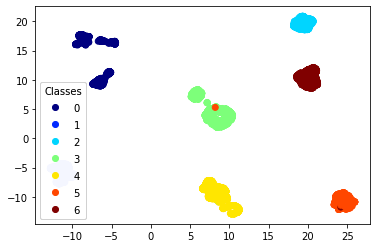

In [16]:
import matplotlib.pyplot as plt
activities = [
    "Sitting",
    "Lying",
    "Standing",
    "Walking",
    "Running",
    "Downstairs",
    "Upstairs"
]

print(activities)
fig, ax = plt.subplots()

scatter = ax.scatter(train_coords[:, 0], train_coords[:, 1], c = y_train, cmap='jet', label='Inline label')

legend1 = ax.legend(*scatter.legend_elements(),
                    loc="lower left", title="Classes")
ax.add_artist(legend1)



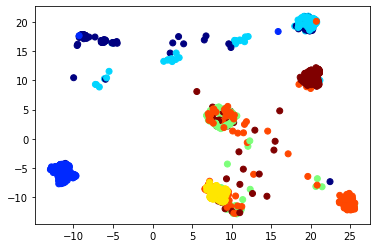

In [17]:
plt.scatter(test_coords[:, 0], test_coords[:, 1], c = y_test, cmap='jet')

In [18]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import LinearSVC
from sklearn import svm

def classify_dataset(X_train, y_train, X_test, y_test):
    # clf = RandomForestClassifier(random_state=0)
    # clf = LinearSVC(dual=False, random_state=123)
    clf = svm.SVC()
    # clf = KNeighborsClassifier()
    clf.fit(X_train, y_train)
    return clf.predict(X_train), clf.predict(X_test)
    

train_pred, test_pred = classify_dataset(train_repr, y_train, test_repr, y_test)



/home/texs/anaconda3/envs/mo445-gpu/lib/python3.10/site-packages/sklearn/utils/validation.py:985: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


In [19]:
from sklearn import metrics

bal_acc_tr = metrics.balanced_accuracy_score(y_train, train_pred)
bal_acc_te = metrics.balanced_accuracy_score(y_test, test_pred)
            
f1_tr = metrics.f1_score(y_train, train_pred, average='weighted')
f1_te = metrics.f1_score(y_test, test_pred, average='weighted')

print("Training balanced accuracy: {} - testing balanced accuracy: {}".format(bal_acc_tr, bal_acc_te))
print("Training f1 score: {} - testing f1 score: {}".format(f1_tr, f1_te))

Training balanced accuracy: 0.9577380952380954 - testing balanced accuracy: 0.7809523809523811
Training f1 score: 0.9570846776076433 - testing f1 score: 0.7758829171915775


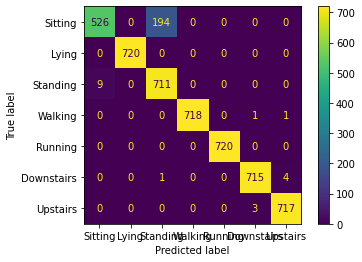

In [20]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

cm_train = confusion_matrix(y_train, train_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm_train, display_labels= activities)
disp.plot()


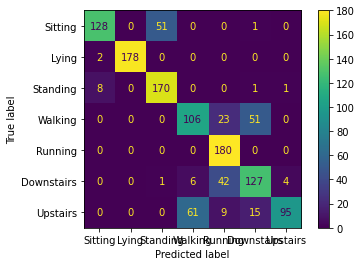

In [21]:
cm_test = confusion_matrix(y_test, test_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm_test, display_labels= activities)
disp.plot()


In [22]:
# import torch
# from torch import nn
# import torch.nn.functional as F
# import numpy as np

# class SamePadConv(nn.Module):
#     def __init__(self, in_channels, out_channels, kernel_size, dilation=1, groups=1):
#         super().__init__()
#         self.receptive_field = (kernel_size - 1) * dilation + 1
#         padding = self.receptive_field // 2
#         self.conv = nn.Conv1d(
#             in_channels, out_channels, kernel_size,
#             padding=padding,
#             dilation=dilation,
#             groups=groups
#         )
#         self.remove = 1 if self.receptive_field % 2 == 0 else 0
        
#     def forward(self, x):
#         out = self.conv(x)
#         if self.remove > 0:
#             out = out[:, :, : -self.remove]
#         return out
    
# class ConvBlock(nn.Module):
#     def __init__(self, in_channels, out_channels, kernel_size, dilation, final=False):
#         super().__init__()
#         self.conv1 = SamePadConv(in_channels, out_channels, kernel_size, dilation=dilation)
#         self.conv2 = SamePadConv(out_channels, out_channels, kernel_size, dilation=dilation)
#         self.projector = nn.Conv1d(in_channels, out_channels, 1) if in_channels != out_channels or final else None
    
#     def forward(self, x):
#         residual = x if self.projector is None else self.projector(x)
#         x = F.gelu(x)
#         x = self.conv1(x)
#         x = F.gelu(x)
#         x = self.conv2(x)
#         return x + residual

# class DilatedConvEncoder(nn.Module):
#     def __init__(self, in_channels, channels, kernel_size):
#         super().__init__()
#         self.net = nn.Sequential(*[
#             ConvBlock(
#                 channels[i-1] if i > 0 else in_channels,
#                 channels[i],
#                 kernel_size=kernel_size,
#                 dilation=2**i,
#                 final=(i == len(channels)-1)
#             )
#             for i in range(len(channels))
#         ])
        
#     def forward(self, x):
#         return self.net(x)
